# Frequency-switched Data Reduction
-----------------------------------

This notebook shows how to use `dysh` to calibrate a frequency switched observations. The idea is similar to an OnOff observation, except the telescope does not move to an Off in position, but move their IF in frequency space. Here we call the On/Off the Sig and Ref. Since the telescope observes in a Track mode, combining the sig and a shifted (folded) ref, a $\sqrt{2}$ improvement in S/N can be achieved.

It retrieves and calibrates frequency-switched scans using `GBTFITSLoad.getfs()`, which returns a `ScanBlock` object.  

In [20]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
import dysh.util as util
import numpy as np

## First, we download the example SDFITS data, if necessary.


In [21]:
# just scan6 
filename = "AGBT20B_014_03.raw.vegas.A6.fits"
if not os.path.isfile(filename):
    url = f"http://www.gb.nrao.edu/dysh/example_data/onoff-L/data/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded")

HTTPError: HTTP Error 404: Not Found

In [22]:
filename = util.get_project_testdata()/"AGBT20B_014_03.raw.vegas/AGBT20B_014_03.raw.vegas.A.fits"

In [23]:
sdfits = GBTFITSLoad(filename)
sdfits.info()
sdfits.summary()

Filename: /home/mpound/src/dysh/testdata/AGBT20B_014_03.raw.vegas/AGBT20B_014_03.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   11840R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '16384E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,72.712573,28.957453
1,7,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,73.97438,30.877035
2,8,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,75.236286,32.809039
3,9,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,76.501272,34.752557
4,10,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,77.77259,36.706691
5,11,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,79.053856,38.670354
6,12,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,80.349081,40.642662
7,13,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,81.662908,42.62274
8,14,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,83.004809,44.616151
9,15,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,84.372033,46.608897


In [24]:
#fsscan = sdfits.getfs(6, ifnum=0, plnum=1)
#    why does this not work, where getps(6) would work???
#
# Answer: getps(6) is no longer correct either.  This was a change when selection was implemented, scan is now a kwarg not a default argument.
fsscan = sdfits.getfs(scan=[6,7], ifnum=0, plnum=1, debug=True)

{'scan': [6, 7], 'ifnum': 0, 'plnum': 1, 'debug': True}
PJT scans/w sel: [6, 7]       OBJECT     BANDWID  ... _SUBOBSMODE                      UTC
0       M33S  16875000.0  ...       FSW12  2020-10-24T23:29:50.000
1       M33S  16875000.0  ...       FSW12  2020-10-24T23:29:50.000
2       M33S  16875000.0  ...       FSW12  2020-10-24T23:29:50.000
3       M33S  16875000.0  ...       FSW12  2020-10-24T23:29:50.000
4       M33S  16875000.0  ...       FSW12  2020-10-24T23:29:50.000
...      ...         ...  ...         ...                      ...
11835   M33S  16875000.0  ...       FSW12  2020-10-25T05:08:12.000
11836   M33S  16875000.0  ...       FSW12  2020-10-25T05:08:12.000
11837   M33S  16875000.0  ...       FSW12  2020-10-25T05:08:12.000
11838   M33S  16875000.0  ...       FSW12  2020-10-25T05:08:12.000
11839   M33S  16875000.0  ...       FSW12  2020-10-25T05:08:12.000

[11840 rows x 81 columns]
SELECTION FROM MIXED KWARGS {'ifnum': 0, 'plnum': 1, 'debug': True, 'scan': [6, 7]}
worki

/home/mpound/src/dysh/src/dysh/spectra/core.py:352: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


Calibrated 11 spectra with fold=True and use_sig=True
---------------------------------------------------


In [25]:
ta = fsscan.timeaverage(weights='tsys')

PJT:   timeaverage
PJT:   timeaverage


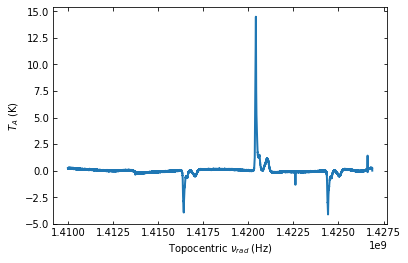

In [26]:
ta.plot()

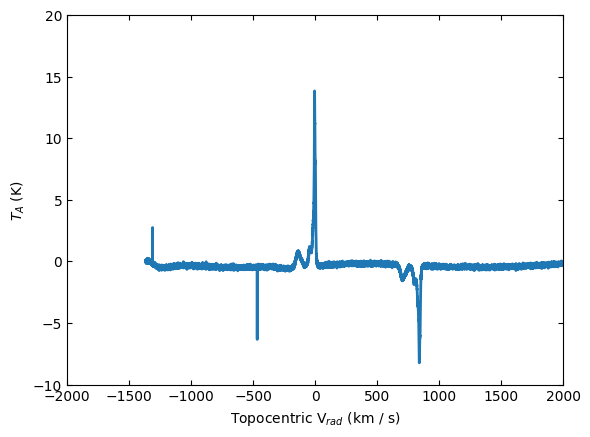

In [13]:
ta.plot(xaxis_unit="km/s",yaxis_unit="K",ymin=-10,ymax=20,xmin=-2000,xmax=2000)

In [16]:
kms = u.km/u.s
#ta.baseline(degree=2,exclude=[(-2000*kms,-400*kms),(-200*kms,100*kms),(600*kms,3000*kms)],remove=True)
ta.baseline(degree=2,exclude=[-200*kms,100*kms],remove=True)

# @todo  we really should have an include= option as well, mutually exclusive

EXCLUDING [Spectral Region, 1 sub-regions:
  (1419929945.1210444 Hz, 1421351333.4469643 Hz) 
]


 [astropy.modeling.fitting]


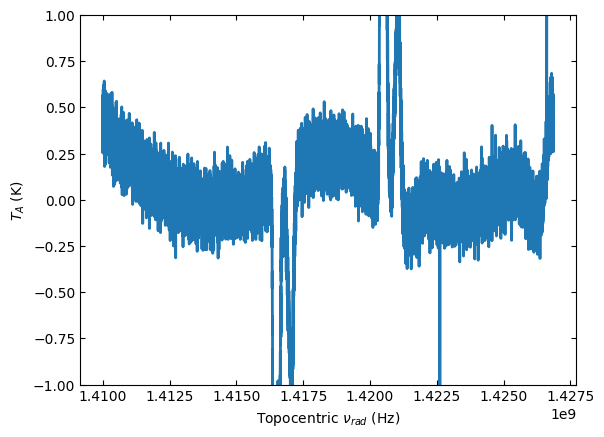

In [17]:
ta.plot(ymin=-1,ymax=1)

In [18]:
print(ta.baseline_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                     c1                      c2          
              K                    K / Hz                 K / Hz2        
    ---------------------- ---------------------- -----------------------
    -8.882452439800267e-17 -3.113706564831629e-44 -1.0914002601893674e-71


In [19]:
ta.savefig("baselined_removed.png")